In [1]:
# Import packages
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score


import seaborn as sns
import matplotlib.pyplot as plt

2024-06-12 10:02:00.161562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-12 10:02:00.161602: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Path to ./data/processed folder
path_data_processed = os.path.join(
    os.path.abspath('../'),
    'data',
    'processed'
)

# Load Data

In [3]:
# Read dataset with AAPL's historic stock prices
df_stocks = pd.read_csv(
    os.path.join(
        path_data_processed,
        'stock_prices_appl.csv'
    ),
    index_col=0
)

# Apply pivot_table
df_stocks = df_stocks.pivot_table(
    values='Close',
    index='Date',
    columns='Stock'
).reset_index(drop=False)

In [4]:
# Read dataset with News' score
df_agg = pd.read_csv(
    os.path.join(
        path_data_processed,
        'analyst_ratings_avg_score_per_label.csv'
    )
)

# Fill NaN with 0, because there wasn't any news with this label
df_agg['positive'] = df_agg['positive'].fillna(0)
df_agg['negative'] = df_agg['negative'].fillna(0)
df_agg['neutral'] = df_agg['neutral'].fillna(0)

In [6]:
# Merge both dataframes on date
df = df_stocks.merge(df_agg, on='Date', how='left')

# Create target column by shifting stock prices
df[f'AAPL_target'] = df['AAPL'].shift(1)

# Data Preparation

In [9]:
# Select features
data = df.drop('Date', axis=1)

# Drop null values
data = data.dropna()

## Train-Test Split

In [11]:
# Set train percentage
train_percentage = 0.95

# Compute lenght of train dataframe
train_len = int(len(data) * train_percentage)

In [12]:
# Create data_train and data_test:
df_train = data.iloc[:train_len]
df_test = data.iloc[train_len:]

<Axes: xlabel='AAPL_target'>

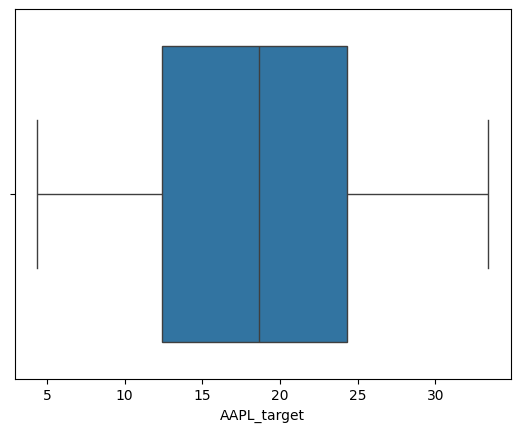

In [15]:
sns.boxplot(data=data, x='AAPL_target')

## Scaling
Transforming numerical features into a common smaller range

In [16]:
# Define features to be scaled
features_scale = ['AAPL']

# Define target columns
target = ['AAPL_target']

# Train MinMaxScaler to apply on the target columns
target_scaler = MinMaxScaler().fit(df_train[target])

# Apply scaler on train and test dataframes
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

# Train MinMaxScaler to apply on the feature columns
features_scaler = MinMaxScaler().fit(df_train[features_scale])

# Apply scaler on train and test dataframes
df_train[features_scale] = features_scaler.transform(df_train[features_scale])
df_test[features_scale] = features_scaler.transform(df_test[features_scale])

/tmp/ipykernel_31154/1299088375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = target_scaler.transform(df_train[target])
/tmp/ipykernel_31154/1299088375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target] = target_scaler.transform(df_test[target])
/tmp/ipykernel_31154/1299088375.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [42]:
# import pickle
# with open('aapl_with_hour_target_scaler_model_v4.pkl','wb') as f:
#     pickle.dump(target_scaler, f)

: 

## Subsequences

In [19]:
# Define funtion to create subsequences
def subsequence(df, length, features, target):
    # Initialize variables
    X, y = [], []

    # Iterate over the dataframe to create subsequences
    for i in range(length, df.shape[0]):
        X.append(df[features].iloc[i - length: i])
        y.append(df[target].iloc[i])

    # Convert X and y into arrays
    X = np.array(X)
    y = np.expand_dims(
        np.array(y).astype(np.float32),
        axis=-1
    )

    return X, y

In [20]:
# Create subsequence with 5 business days X 4 weeks X 3 months
length = 5 * 4 * 3

features = [
    'AAPL',
    'negative',
    'neutral',
    'positive'
]

# Create train subsequences
X_train, y_train = subsequence(df_train, length, features, target)

# Create test subsequences
X_test, y_test = subsequence(df_test, length, features, target)

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319


## Regularizer

In [23]:
# Reshape X_train
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Reshape y_train
y_train_reshaped = y_train.reshape(y_train.shape[0], -1)

# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [25]:
# Apply Elastic Net
# Define parameters
alpha = 0.1
l1_ratio = 0.5  # Ratio of L1 to L2 penalty (0.5 means equal penalties)

# Create Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('elasticnet', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
])

# Apply .fit
pipe.fit(X_train_reshaped, y_train_reshaped)

# Apply redict
y_pred = pipe.predict(X_test_reshaped)

/home/nathalia/.pyenv/versions/3.10.6/envs/stocks_vs_behavior/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 7.310e-02
  model = cd_fast.enet_coordinate_descent(


# RNN Model

In [26]:
# Padding train and test
X_train_pad = pad_sequences(X_train, value=-999, padding='post', dtype='float64')
X_test_pad = pad_sequences(X_test, value=-999, padding='post', dtype='float64')

In [27]:
# Build the model
def rnn_model():
    model = Sequential()

    model.add(layers.Masking(mask_value=-999))

    model.add(
        layers.GRU(
            units=128,
            return_sequences=True,
            activation="tanh",
            input_shape=X_train_pad[0].shape
        )
    )

    model.add(
        layers.GRU(
            units=64,
            return_sequences=False,
            activation="tanh"
        )
    )

    model.add(layers.Dense(25, activation="relu"))

    model.add(layers.Dense(1, activation="relu"))

    my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

    model.compile(
        loss="mse",
        optimizer="rmsprop",
        metrics=[my_mae]
    )

    return model

model = rnn_model()

2024-06-12 10:02:16.726881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-12 10:02:16.726950: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-12 10:02:16.726975: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BOOK-ALBTG24FIF): /proc/driver/nvidia/version does not exist
2024-06-12 10:02:16.727312: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
%%time

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

history = model.fit(
    X_train_pad,
    np.array(y_train),
    validation_split = 0.3,
    batch_size=16,
    epochs=300,
    verbose = 1,
    callbacks = [es]
)

Epoch 1/300
498/498 [==============================] - 58s 105ms/step - loss: 0.0032 - mean_absolute_error: 0.0415 - val_loss: 0.0013 - val_mean_absolute_error: 0.0331
Epoch 2/300
498/498 [==============================] - 51s 102ms/step - loss: 7.9248e-04 - mean_absolute_error: 0.0234 - val_loss: 7.4234e-04 - val_mean_absolute_error: 0.0244
Epoch 3/300
498/498 [==============================] - 51s 101ms/step - loss: 5.3763e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0034 - val_mean_absolute_error: 0.0560
Epoch 4/300
498/498 [==============================] - 51s 102ms/step - loss: 4.0760e-04 - mean_absolute_error: 0.0167 - val_loss: 9.5430e-04 - val_mean_absolute_error: 0.0290
Epoch 5/300
498/498 [==============================] - 50s 101ms/step - loss: 3.4311e-04 - mean_absolute_error: 0.0150 - val_loss: 2.5429e-04 - val_mean_absolute_error: 0.0139
Epoch 6/300
498/498 [==============================] - 50s 101ms/step - loss: 2.8987e-04 - mean_absolute_error: 0.0140 - val_loss: 1

In [41]:
# model.save(
#     os.path.join(
#         os.path.abspath('../'),
#         'models',
#         'aapl_per_hour_model_with_gru_and_avg_score_per_label_v4.keras'
#     )
# )

In [30]:
for i in history.history.keys():
    value = np.mean(history.history[i])
    print(i, " = ", value)

loss  =  0.00027479398636387486
mean_absolute_error  =  0.011438438988989219
val_loss  =  0.0007388772837657598
val_mean_absolute_error  =  0.021364671862102114


In [32]:
def plot_loss_mae(history):

    fig, ax =plt.subplots(1,2,figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    plt.show()

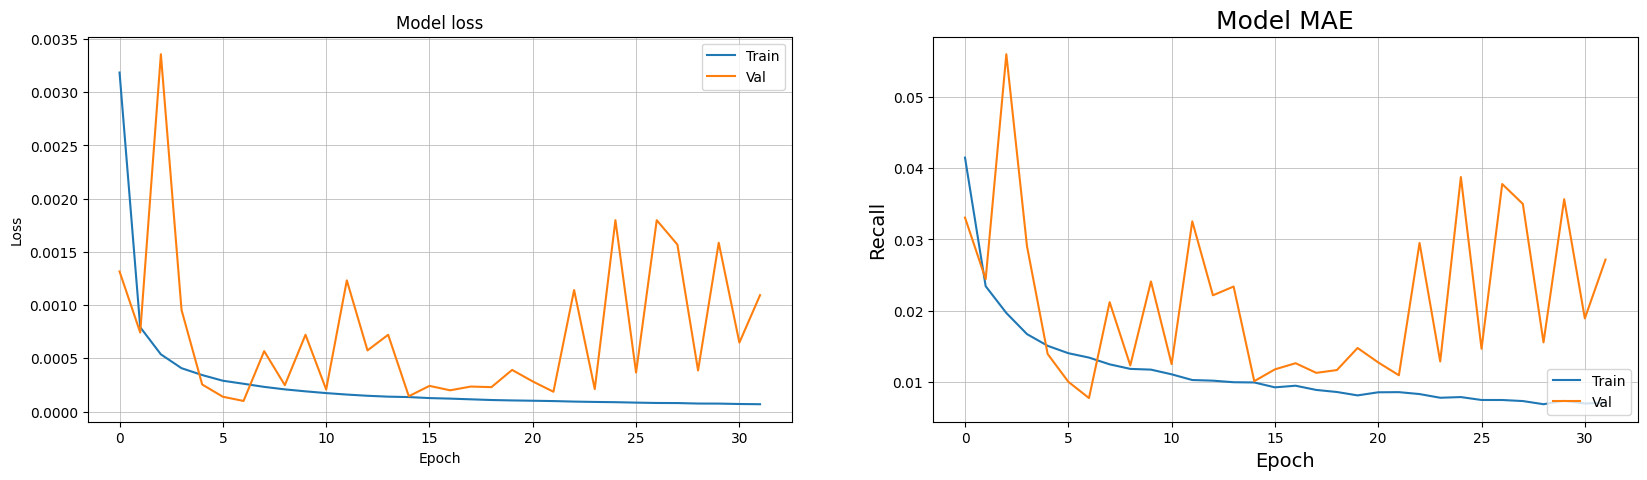

In [33]:
plot_loss_mae(history)

In [34]:
y_pred = target_scaler.inverse_transform(model.predict(X_test))
y_test2 = y_test[:, 0, 0]

In [40]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

0.9287478923797607

In [ ]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

-172.70602416992188

In [40]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

0.8169159889221191

In [ ]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

0.9836274981498718